# Assignment 3.2

# Sequence classification model

In [1]:
from __future__ import print_function

## 1. Preprocess data

#### Tasks:

* Create word vocabulary index (use 10.000 most frequent words)
* Preprocess training and validation set for model input. Use vocabulary index as lookup dictionary to transform raw text into integer sequences. You may use code from Practical 5.

In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
import re
import nltk

In [3]:
DATA_PATH = "data_part2"
EMBEDDINGS_PATH = "embeddings_part2"
MODEL_PATH = "models_part2"
VALID_DATA_SIZE = 500

In [4]:
# function to clean raw text data

def striphtml(html):
    p = re.compile(r'<.*?>')
    return p.sub('', html)

def clean(s):
    return re.sub(r'[^\x00-\x7f]', r'', s)

In [5]:
complete_train_data = pd.read_csv(os.path.join(DATA_PATH,"trainingData.tsv"), header=0, delimiter="\t")

In [6]:
complete_valid_data = pd.read_csv(os.path.join(DATA_PATH,"validationData.tsv"), header=0, delimiter="\t")

In [7]:
print(type(complete_valid_data))
print(complete_train_data.shape)
print(complete_valid_data.shape)


<class 'pandas.core.frame.DataFrame'>
(25000, 3)
(25000, 2)


In [8]:
## Maybe need to change this values for randomized versions
#train_data = complete_train_data[].sample(frac=0.8)
#valid_data = complete_valid_data.sample(frac=0.2)
train_data = complete_train_data[:20000]
valid_data = complete_valid_data[:5000]
unseen_valid_data = complete_valid_data[5000:10000]
test_data = complete_valid_data[10000:15000]
print(len(train_data))
print(len(valid_data))
print(len(unseen_valid_data))
print(len(test_data))

20000
5000
5000
5000


## Clean training, validation, unseen validation, and test sets

In [9]:

train_docs = []
train_labels = []
for cont, sentiment in zip(train_data.review, train_data.sentiment):
    
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    train_docs.append(doc)
    train_labels.append(sentiment)
    
# this  will create a cleaned version of validation set
# we also need to extract labels from attribute 'id'

valid_docs =[]
valid_labels = []
i=0
for docid,cont in zip(valid_data.id, valid_data.review):
    
    id_label = docid.split('_')
    # if rating >= 7, then assign 1 (positive sentiment) as label
    if(int(id_label[1]) >= 7):
        valid_labels.append(1)
    # else, assign 0 (negative sentiment) as label
    else:
        valid_labels.append(0)         
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    valid_docs.append(doc)
    
unseen_valid_docs = []
unseen_valid_labels = []
i = 0
for docid,cont in zip(unseen_valid_data.id, unseen_valid_data.review):
    
    id_label = docid.split('_')
    # if rating >= 7, then assign 1 (positive sentiment) as label
    if(int(id_label[1]) >= 7):
        unseen_valid_labels.append(1)
    # else, assign 0 (negative sentiment) as label
    else:
        unseen_valid_labels.append(0)         
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    unseen_valid_docs.append(doc)

    
test_docs = []
test_labels = []
i = 0
for docid,cont in zip(test_data.id, test_data.review):
    
    id_label = docid.split('_')
    # if rating >= 7, then assign 1 (positive sentiment) as label
    if(int(id_label[1]) >= 7):
        test_labels.append(1)
    # else, assign 0 (negative sentiment) as label
    else:
        test_labels.append(0)         
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    test_docs.append(doc)

In [10]:
print("Length of train docs: {}, length of train labels: {}".format(len(train_docs), len(train_labels)))
print("Length of validation docs: {}, length of validation labels: {}".format(len(valid_docs), len(valid_labels)))
print("Length of unseen validation docs: {}, length of unseen validation labels: {}".format(len(unseen_valid_docs), 
                                                                                            len(unseen_valid_labels)))
print("Length of test docs: {}, length of test labels: {}".format(len(test_docs), len(test_labels)))


Length of train docs: 20000, length of train labels: 20000
Length of validation docs: 5000, length of validation labels: 5000
Length of unseen validation docs: 5000, length of unseen validation labels: 5000
Length of test docs: 5000, length of test labels: 5000


## Create vocabulary index

In [11]:
# FUNCTION to tokenize documents into array list of words
# you may also use nltk tokenizer, sklearn tokenizer, or keras tokenizer - 
# but for the tutorial in text modeling, we will use below function: 

def tokenizeWords(text):
    
    ## any sequence of non alphanumerical characters is replaced by a space
    tokens = re.sub(r"[^a-z0-9]+", " ", text.lower()).split()
    return [str(strtokens) for strtokens in tokens]

# FUNCTION to create word-level vocabulary index

def indexingVocabulary(array_of_words):

    wordIndex = list(array_of_words)
    
    # we will later pad our sequence into fixed length, so
    # we will use '0' as the integer index of pad 
    wordIndex.insert(0,'<pad>')
    
    # index for word token '<start>' as a starting sign of sequence. We won't use it for this model
    # but for the latter model (sequence-to-sequence model)
    wordIndex.append('<start>')
    
    # index for word token '<end>' as an ending sign of sequence. We won't use it for this model
    # but for the latter model (sequence-to-sequence model)
    wordIndex.append('<end>')
    
    # index for word token '<unk>' or unknown words (out of vocabulary words) 
    wordIndex.append('<unk>')
    
    vocab=dict([(i,wordIndex[i]) for i in range(len(wordIndex))])
    
    return vocab

In [12]:
# tokenize text from training set

train_str_tokens = []
all_tokens = []
for i, text in enumerate(train_docs):
    
    # this will create our training corpus
    train_str_tokens.append(tokenizeWords(text))
    
    # this will be our merged array to create vocabulary index
    all_tokens.extend(tokenizeWords(text))

In [13]:
print(train_str_tokens[:2])
print(all_tokens[:5])

[['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again', 'maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent', 'moonwalker', 'is', 'part', 'biography', 'part', 'feature', 'film', 'which', 'i', 'remember', 'going', 'to', 'see', 'at', 'the', 'cinema', 'when', 'it', 'was', 'originally', 'released', 'some', 'of', 'it', 'has', 'subtle', 'messages', 'about', 'mj', 's', 'feeling', 'towards', 'the', 'press', 'and', 'also', 'the', 'obvious', 'message', 'of', 'drugs', 'are', 'bad', 'm', 'kay', 'visually', 'impressive', 'but', 'of', 'course', 'this', 'is', 'all', 'about',

In [14]:
# likewise, tokenize text from validation, unseen validation, and test sets

valid_str_tokens = []
for i, text in enumerate(valid_docs):
    valid_str_tokens.append(tokenizeWords(text))
    
unseen_valid_str_tokens = []
for i, text in enumerate(unseen_valid_docs):
    unseen_valid_str_tokens.append(tokenizeWords(text))
    
test_str_tokens = []
for i, text in enumerate(test_docs):
    test_str_tokens.append(tokenizeWords(text))
    

In [15]:
# use nltk to count word frequency and use 10.000 most frequent words to generate vocabulary index

tf = nltk.FreqDist(all_tokens)
common_words = tf.most_common(10000)
arr_common = np.array(common_words)
words = arr_common[:,0]

# create vocabulary index

# word- index pairs
words_indices = indexingVocabulary(words)

# index - word pairs
indices_words = dict((v,k) for (k,v) in words_indices.items())

In [16]:
# save vocabulary index

np.save(os.path.join(DATA_PATH,'words_indices.npy'), words_indices)
np.save(os.path.join(DATA_PATH,'indices_words.npy'), indices_words)

## Prepare model input and output

In [17]:
# integer format of training input 
train_int_input = []
for i, text in enumerate(train_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    train_int_input.append(int_tokens)
    
# integer format of validation input 
valid_int_input = []
for i, text in enumerate(valid_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    valid_int_input.append(int_tokens)
    
# integer format of unseen validation input
unseen_valid_int_input = []
for i, text in enumerate(unseen_valid_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    unseen_valid_int_input.append(int_tokens)

# integer format of test input
test_int_input = []
for i, text in enumerate(test_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    test_int_input.append(int_tokens)
    

In [18]:
X_train_arr = np.array(train_int_input)
y_train = np.array(train_labels)

X_validation_arr = np.array(valid_int_input)
y_validation = np.array(valid_labels)

X_unseen_validation_arr = np.array(unseen_valid_int_input)
y_unseen_validation = np.array(unseen_valid_labels)

X_test_arr = np.array(test_int_input)
y_test = np.array(test_labels)

In [19]:
from keras.preprocessing import sequence

## think about what will happen if we use 'post' padding instead of 'pre' padding
max_review_length = 500
X_train = sequence.pad_sequences(X_train_arr, maxlen=max_review_length, value=0)
X_validation = sequence.pad_sequences(X_validation_arr, maxlen=max_review_length, value=0)
X_unseen_validation = sequence.pad_sequences(X_unseen_validation_arr, maxlen=max_review_length, value=0)
X_test = sequence.pad_sequences(X_test_arr, maxlen=max_review_length, value=0)

/home/jorge/.local/share/virtualenvs/RecommenderSystems-c5N1t04d/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
# save files

np.save(os.path.join(DATA_PATH,'X_train_word.npy'), X_train)
np.save(os.path.join(DATA_PATH,'y_train_word.npy'), y_train)

np.save(os.path.join(DATA_PATH,'X_validation_word.npy'), X_validation)
np.save(os.path.join(DATA_PATH,'y_validation_word.npy'), y_validation)

np.save(os.path.join(DATA_PATH, 'X_unseen_validation_word.npy'), X_unseen_validation)
np.save(os.path.join(DATA_PATH, 'y_unseen_validation_word.npy'), y_unseen_validation)

np.save(os.path.join(DATA_PATH, 'X_test_word.npy'), X_test)
np.save(os.path.join(DATA_PATH, 'y_test_word.npy'), y_test)

## 2. Sequence classification model

#### Tasks: 

* Create a RNN model to classify sequence of words on a binary classification task
* Compare four (4) different gate memory units
* Plot model performance (loss and accuracy) of these 4 models
* Present the performance (loss and accuarcy) of these 4 models in a comparison table

In [21]:
from keras.utils.np_utils import to_categorical

y_train_labels = to_categorical(y_train)
y_validation_labels = to_categorical(y_validation)

print(np.unique(y_train_labels))
print(np.unique(y_validation_labels))
print(len(words_indices))
print(y_train[:5])
print(np.unique(y_train))
print(X_train.shape)

#y_train_labels = 

[0. 1.]
[0. 1.]
10004
[1 1 0 0 1]
[0 1]
(20000, 500)


In [22]:
# YOUR CODE HERE 

from keras.layers import Embedding, Input, LSTM, Dense, GRU, Bidirectional
from keras.models import Model

# decide number of epochs and batch_size
models_num_epochs = 15
models_batch_size = 256
embedding_size = 100

### Model 1 : LSTM

In [23]:
# YOUR CODE HERE
# MODEL-1: LSTM

# construct the model
sequence_input = Input(shape=(max_review_length,), name='input_layer', dtype='int32')
embedding_layer = Embedding(len(words_indices), embedding_size, input_length=max_review_length, name='word_embedding')
embedded_sequences = embedding_layer(sequence_input)
lstm_layer = LSTM(embedding_size, name='lstm_layer')(embedded_sequences)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(lstm_layer)

lstm_model = Model(sequence_input, output_layer)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 500)               0         
_________________________________________________________________
word_embedding (Embedding)   (None, 500, 100)          1000400   
_________________________________________________________________
lstm_layer (LSTM)            (None, 100)               80400     
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 101       
Total params: 1,080,901
Trainable params: 1,080,901
Non-trainable params: 0
_________________________________________________________________


### Model 2: GRU

In [24]:
# YOUR CODE HERE
# MODEL-2: GRU

# construct the model
sequence_input = Input(shape=(max_review_length,), name='input_layer', dtype='int32')
embedding_layer = Embedding(len(words_indices), embedding_size, input_length=max_review_length, name='word_embedding')
embedded_sequences = embedding_layer(sequence_input)
gru_layer = GRU(embedding_size, name='gru_layer')(embedded_sequences)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(gru_layer)

gru_model = Model(sequence_input, output_layer)
gru_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 500)               0         
_________________________________________________________________
word_embedding (Embedding)   (None, 500, 100)          1000400   
_________________________________________________________________
gru_layer (GRU)              (None, 100)               60300     
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 101       
Total params: 1,060,801
Trainable params: 1,060,801
Non-trainable params: 0
_________________________________________________________________


### Model 3 : Bidirectional LSTM

In [25]:
# YOUR CODE HERE
# MODEL-3: Bidirectional LSTM

# construct the model
sequence_input = Input(shape=(max_review_length,), name='input_layer', dtype='int32')
embedding_layer = Embedding(len(words_indices), embedding_size, input_length=max_review_length, name='word_embedding')
embedded_sequences = embedding_layer(sequence_input)
bilstm_layer = Bidirectional(LSTM(embedding_size, name='bilstm_layer'))(embedded_sequences)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(bilstm_layer)

bilstm_model = Model(sequence_input, output_layer)
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 500)               0         
_________________________________________________________________
word_embedding (Embedding)   (None, 500, 100)          1000400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 201       
Total params: 1,161,401
Trainable params: 1,161,401
Non-trainable params: 0
_________________________________________________________________


### Model 4 : Bidirectional GRU

In [26]:
# YOUR CODE HERE
# MODEL-4: Bidirectional GRU

# construct the model
sequence_input = Input(shape=(max_review_length,), name='input_layer', dtype='int32')
embedding_layer = Embedding(len(words_indices), embedding_size, input_length=max_review_length, name='word_embedding')
embedded_sequences = embedding_layer(sequence_input)
bigru_layer = Bidirectional(GRU(embedding_size, name='bigru_layer'))(embedded_sequences)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(bigru_layer)

bigru_model = Model(sequence_input, output_layer)
bigru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 500)               0         
_________________________________________________________________
word_embedding (Embedding)   (None, 500, 100)          1000400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               120600    
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 201       
Total params: 1,121,201
Trainable params: 1,121,201
Non-trainable params: 0
_________________________________________________________________


### Compile models

In [27]:
# YOUR CODE HERE 
# decide loss function, and optimizer
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
# YOUR CODE HERE 
# decide loss function, and optimizer
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# YOUR CODE HERE 
# decide loss function, and optimizer
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# YOUR CODE HERE 
# decide loss function, and optimizer
bigru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train models

In [31]:
# YOUR CODE HERE 
# add callback history during the training stage of the model
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), \
               epochs=models_num_epochs, batch_size=models_batch_size)

gru_history = gru_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), \
               epochs=models_num_epochs, batch_size=models_batch_size)

bilstm_history = bilstm_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), \
               epochs=models_num_epochs, batch_size=models_batch_size)

bigru_history = bigru_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), \
               epochs=models_num_epochs, batch_size=models_batch_size)

Train on 20000 samples, validate on 5000 samples
Epoch 1/15
20000/20000 [==============================] - 240s 12ms/step - loss: 0.5968 - acc: 0.6955 - val_loss: 0.4255 - val_acc: 0.8148
Epoch 2/15
20000/20000 [==============================] - 245s 12ms/step - loss: 0.2984 - acc: 0.8774 - val_loss: 0.3002 - val_acc: 0.8744
Epoch 3/15
20000/20000 [==============================] - 243s 12ms/step - loss: 0.2021 - acc: 0.9257 - val_loss: 0.3215 - val_acc: 0.8720
Epoch 4/15
20000/20000 [==============================] - 261s 13ms/step - loss: 0.1582 - acc: 0.9432 - val_loss: 0.3398 - val_acc: 0.8658
Epoch 5/15
20000/20000 [==============================] - 255s 13ms/step - loss: 0.1153 - acc: 0.9624 - val_loss: 0.4055 - val_acc: 0.8568
Epoch 6/15
20000/20000 [==============================] - 231s 12ms/step - loss: 0.0874 - acc: 0.9722 - val_loss: 0.4525 - val_acc: 0.8576
Epoch 7/15
20000/20000 [==============================] - 227s 11ms/step - loss: 0.0642 - acc: 0.9804 - val_loss: 0.4

20000/20000 [==============================] - 353s 18ms/step - loss: 0.0341 - acc: 0.9903 - val_loss: 0.7226 - val_acc: 0.8314
Epoch 14/15
20000/20000 [==============================] - 353s 18ms/step - loss: 0.0230 - acc: 0.9946 - val_loss: 0.8346 - val_acc: 0.8240
Epoch 15/15
20000/20000 [==============================] - 353s 18ms/step - loss: 0.0178 - acc: 0.9965 - val_loss: 0.8630 - val_acc: 0.8292


### Save models and weight parameters

In [32]:
# Save model
lstm_model.save('lstm_model.h5')
# Save trained weight parameters
lstm_model.save_weights('weights_lstm_model.hdf5')

In [33]:
# Save model
gru_model.save('gru_model.h5')
# Save trained weight parameters
gru_model.save_weights('weights_gru_model.hdf5')

In [34]:
# Save model
bilstm_model.save('bilstm_model.h5')
# Save trained weight parameters
bilstm_model.save_weights('weights_bilstm_model.hdf5')

In [35]:
# Save model
bigru_model.save('bigru_model.h5')
# Save trained weight parameters
bigru_model.save_weights('weights_bigru_model.hdf5')

#### Plot model performance (loss, accuracy)

Present two (2) plots for each model 

In [36]:
# YOUR CODE HERE 
import matplotlib.pyplot as plt

def plot_accuracy(model_history, model_title):
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title(model_title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plot_loss(model_history, model_title):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title(model_title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

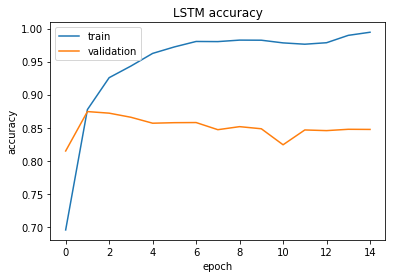

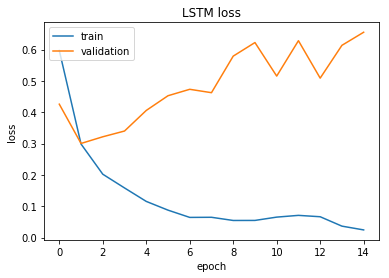

In [37]:
plot_accuracy(lstm_history, 'LSTM accuracy')
plot_loss(lstm_history, 'LSTM loss')

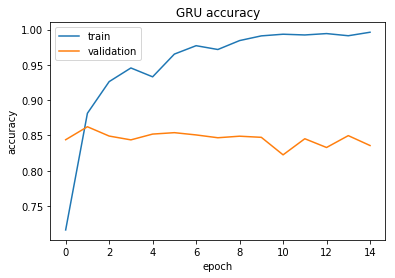

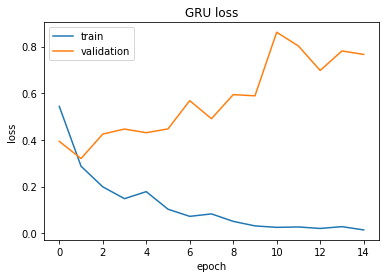

In [38]:
plot_accuracy(gru_history, 'GRU accuracy')
plot_loss(gru_history, 'GRU loss')


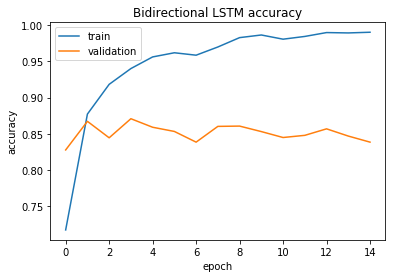

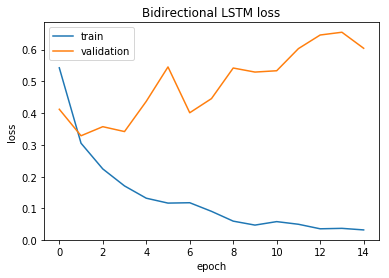

In [39]:
plot_accuracy(bilstm_history, 'Bidirectional LSTM accuracy')
plot_loss(bilstm_history, 'Bidirectional LSTM loss')


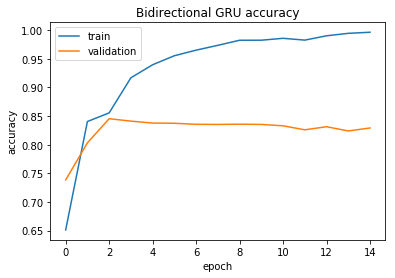

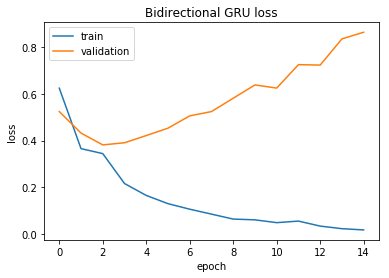

In [40]:
plot_accuracy(bigru_history, 'Bidirectional GRU accuracy')
plot_loss(bigru_history, 'Bidirectional GRU loss')

In [41]:
## create pandas table
[lstm_uvalid_loss, lstm_uvalid_acc] = lstm_model.evaluate(X_unseen_validation, y_unseen_validation)
[gru_uvalid_loss, gru_uvalid_acc] = gru_model.evaluate(X_unseen_validation, y_unseen_validation)
[bilstm_uvalid_loss, bilstm_uvalid_acc] = bilstm_model.evaluate(X_unseen_validation, y_unseen_validation)
[bigru_uvalid_loss, bigru_uvalid_acc] = bigru_model.evaluate(X_unseen_validation, y_unseen_validation)


5000/5000 [==============================] - 28s 6ms/step


In [42]:
tdata = {'loss': pd.Series([lstm_uvalid_loss, gru_uvalid_loss, bilstm_uvalid_loss, bigru_uvalid_loss],
                           index=['lstm', 'gru', 'bi-lstm', 'bi-gru']),
        'accuracy': pd.Series([lstm_uvalid_acc, gru_uvalid_acc, bilstm_uvalid_acc, bigru_uvalid_acc],
                              index=['lstm', 'gru', 'bi-lstm', 'bi-gru'])}
uvalid_df = pd.DataFrame(tdata)


#### Present table comparison of model performance

In [43]:
print("Accuracy and loss for models using unseen validation data: \n")
print(uvalid_df)

Accuracy and loss for models using unseen validation data: 

         accuracy      loss
lstm       0.8384  0.705291
gru        0.8360  0.760174
bi-lstm    0.8352  0.618919
bi-gru     0.8310  0.873349


### 3. Feature extraction

#### Tasks: 

* Choose one model with the best performance and use the model to produce ”neural codes” (document embedding) of raw text (5000 instances of unseen validation set) from RNN layer.
*  Use tSNE to reduce the dimension of extracted text features (encoded version of 5000 documents) into two (2) dimensions and visualize it towards their sentiment labels.


In [44]:
# load the trained model
from keras.models import load_model

# YOUR CODE HERE
# choose the best model

model = load_model('lstm_model.h5')
model.load_weights('weights_lstm_model.hdf5')
model_encoder = Model(inputs=model.input, outputs=model.get_layer("word_embedding").output)


#### Produce Neural codes of text reviews

In [45]:
# YOUR CODE HERE
# generate "neural codes" (document embedding) from the model
doc_embedding = model_encoder.predict(X_test)

In [46]:
from sklearn.decomposition import PCA

dimData = np.prod(doc_embedding.shape[1:])
doc_embedding_flat = doc_embedding.reshape((doc_embedding.shape[0], -1))
pca = PCA(n_components=500)
pca.fit(doc_embedding_flat)
reduced_doc_embedding = pca.transform(doc_embedding_flat)

print(doc_embedding.shape)
print(dimData)
#print(doc_embedding[0])
print(doc_embedding_flat.shape)
print(reduced_doc_embedding.shape)


(5000, 500, 100)
50000
(5000, 50000)
(5000, 500)


#### tSNE visualization

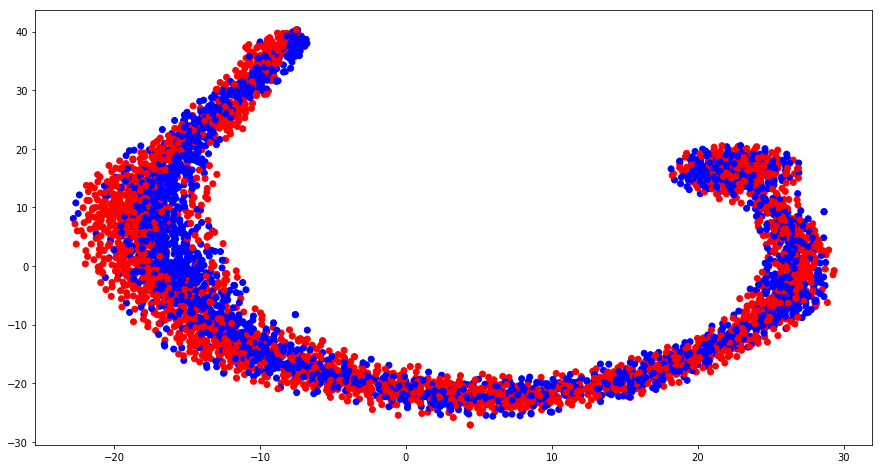

In [47]:
# YOUR CODE HERE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

color_names = ["red", "blue"]
colors = []
for label in y_test:
    # negative label
    if label == 0:
        colors.append("red")
    # positive label
    else:
        colors.append("blue")

# use tSNE to plot document embedding on its sentiment label
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_test_projection = tsne.fit_transform(reduced_doc_embedding).T
fig = plt.figure(figsize=(15, 8))
plt.scatter(X_test_projection[0],
            X_test_projection[1],
            c=colors)
plt.show()

### 4. One shot learning on multi-class classification

#### Tasks: 

* Use the RNN model that has been trained on binary classification task to extract features from different data set (Amazon product reviews)
* Define and implement an approach to assign labels on unlabelled set of reviews, by using the concept of "one shot learning"
* Compute accuracy, given ground truth labels
* Discuss the results 

Explain how the approach works.


#### Answer:

=== write your answer here ===

In [48]:
# load datasets
amazon_labelled_data = pd.read_csv(os.path.join(DATA_PATH,"example1_labelled.tsv"), header=0, delimiter="\t")
amazon_unlabelled_data = pd.read_csv(os.path.join(DATA_PATH,"example2_unlabelled.tsv"), header=0, delimiter="\t")
print(amazon_labelled_data)
print(amazon_unlabelled_data)

         label                                             review
0       camera  My husband bought this camera about 3 months a...
1       laptop  I got this notebook several months ago and I'v...
2  mobilephone  I have this phone for about 10 months.  The ca...
                                              review
0  I purchased the 20d in Feb 2011, around 7 year...
1  It's been 3 weeks now and I've only had minor ...
2  I purchased this Z Series laptop about 5 month...
3  When I first got this laptop (at a garage sale...
4  I love this phone. I've had my own for over a ...
5  I purchased this camera to replace my Casio EX...
6  My perfect camera has to do two things very we...


In [49]:
# process datasets
amazon_train_docs = []
amazon_labels_dict = {}
amazon_train_labels = []
i = 0
for cont, label in zip(amazon_labelled_data.review, amazon_labelled_data.label):
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    amazon_train_docs.append(doc)
    amazon_labels_dict[i] = label
    amazon_train_labels.append(i)
    i+=1
    
print(amazon_labels_dict)
    
amazon_test_docs =[]
amazon_test_labels = []
for cont in amazon_unlabelled_data.review:
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    amazon_test_docs.append(doc)
    
# create tokens
amazon_train_str_tokens = []
for text in amazon_train_docs:
    amazon_train_str_tokens.append(tokenizeWords(text))
    
amazon_test_str_tokens = []
for text in amazon_test_docs:
    amazon_test_str_tokens.append(tokenizeWords(text))

    
# create list of list of numeric tokens
amazon_train_int_input = []
for i, text in enumerate(amazon_train_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    amazon_train_int_input.append(int_tokens)

amazon_test_int_input = []
for i, text in enumerate(amazon_test_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    amazon_test_int_input.append(int_tokens)
    

## represent training and test sets as arrays
from keras.utils.np_utils import to_categorical
X_amazon_train_arr = np.array(amazon_train_int_input)
y_amazon_train = to_categorical(np.array(amazon_train_labels))
#print(y_amazon_train)
X_amazon_test_arr = np.array(amazon_test_int_input)
#y_amazon_test = np.array()

## Apply padding to the sequences
from keras.preprocessing import sequence

max_review_length = 500
X_amazon_train = sequence.pad_sequences(X_amazon_train_arr, maxlen=max_review_length, value=0)
X_amazon_test = sequence.pad_sequences(X_amazon_test_arr, maxlen=max_review_length, value=0)


{0: 'camera', 1: 'laptop', 2: 'mobilephone'}


In [50]:
from keras.models import load_model
from keras.layers import Embedding, Input, LSTM, Dense, GRU, Bidirectional
from keras.models import Model

num_epochs = 15

## load best model
model = load_model('lstm_model.h5')
model.load_weights('weights_lstm_model.hdf5')
## Select part of the model
model_encoder = Model(inputs=model.input, outputs=model.get_layer("lstm_layer").output)
## Add dense layer to the model
model_output = Dense(3, name='prediction_layer', activation='softmax')(model_encoder.output)
prediction_model = Model(model_encoder.input, model_output)
print(prediction_model.summary())

## Compile and train
prediction_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
prediction_model.fit(X_amazon_train, y_amazon_train, epochs=num_epochs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 500)               0         
_________________________________________________________________
word_embedding (Embedding)   (None, 500, 100)          1000400   
_________________________________________________________________
lstm_layer (LSTM)            (None, 100)               80400     
_________________________________________________________________
prediction_layer (Dense)     (None, 3)                 303       
Total params: 1,081,103
Trainable params: 1,081,103
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
3/3 [==============================] - 2s 675ms/step - loss: 1.0835 - acc: 0.6667
Epoch 2/15
3/3 [==============================] - 0s 91ms/step - loss: 0.9968 - acc: 0.3333
Epoch 3/15
3/3 [==============================] - 0s 76ms/step - loss: 0.8

In [51]:
## Generate predictions
predictions = prediction_model.predict(X_amazon_test)
#print(predictions)
#print(np.argmax(predictions, axis=1).tolist())
#print(len(amazon_test_str_tokens))
for i, prediction in enumerate(np.argmax(predictions, axis=1).tolist()):
    print("Review number {} has label {}".format(i, amazon_labels_dict[prediction]))


Review number 0 has label camera
Review number 1 has label camera
Review number 2 has label laptop
Review number 3 has label laptop
Review number 4 has label camera
Review number 5 has label camera
Review number 6 has label laptop


In [52]:
print(amazon_unlabelled_data.review[0][:120])
print(amazon_unlabelled_data.review[1][:120])
print(amazon_unlabelled_data.review[2][:120])
print(amazon_unlabelled_data.review[3][:120])
print(amazon_unlabelled_data.review[4][:120])
print(amazon_unlabelled_data.review[5][:120])
print(amazon_unlabelled_data.review[6][:120])
#print(amazon)

I purchased the 20d in Feb 2011, around 7 years after it was first introduced. The camera was so good built that it look
It's been 3 weeks now and I've only had minor voice mail setup issues.  The phone itself is the best I've had in years. 
I purchased this Z Series laptop about 5 months ago, its my first Sony laptop, Im a Mac fan, but not any more I guess...
When I first got this laptop (at a garage sale, broken) It was really slow and leggy so I installed Linux Mint.  Right a
I love this phone. I've had my own for over a year now and have since bought one for my son and for my daughter. Battery
I purchased this camera to replace my Casio EX-Z4 which broke.  This camera takes great photos.  The controls are much e
My perfect camera has to do two things very well.  First, it has to deliver superior results.  Second, it has to be port


By reading the reviews for the unlabelled data we can assing the following labels: 
* camera 
* mobilephone 
* laptop
* laptop
* mobilephone
* camera
* camera

Therefore, the overall accuracy for our one shot learning approach is 2/7

Discuss the result. Why it works -- or why it does not work.

#### Answer:

The model doesn't seem to work. This happens because ...